In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l
from mdl import attention as mdl

# 自注意力和位置编码
在深度学习中, 经常使用卷积神经网络或者循环神经网络来对于序列进行编码, 有了注意力机制之后, 可以把词元序列输入到注意力池中, 以便同一组词元同时充当查询、键和值, 具体来说, 具体来说, 每一个查询都会关注所有的键-值对并且生成一个注意力输出, 有与查询、键和值来自同一组输入, 所以被称为**自注意力**, 也叫做内部注意力

## 自注意力
给定一个有词元组成的输入序列 $\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n$, 其中任意 $\mathbf{x}_i \in \mathbb{R}^d$, 该序列的自注意力输出为一个长度相同的序列$\mathbf{y}_1, \ldots, \mathbf{y}_n$, 并且其中:
$$
\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x_1}), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d
$$
其中 $f$ 为注意力汇聚函数, 下面的代码片段是基于多头注意力对一个张量完成自注意力的计算, 张量的形状为 `(批量大小, 时间步的数目或者词元序列的长度, d)`, 输出和输入张量形状相同

In [2]:
# 多头注意力模型对于一个张量进行自注意力计算
# 张量形状 -> (批量大小, 时间步数目或者词元序列的长度, d)
num_hiddens, num_heads = 100, 5
attention = mdl.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                  num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [4]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape  # 注意自注意力计算方式

torch.Size([2, 4, 100])

## CNN, RNN 和自注意力比较
上面的几种架构, 目标都是将由 $n$ 个词元组成的序列映射到另外一个长度相等的序列, 其中的每一个输入词元或者输出词元都使用 $d$ 维向量表示 ; 下面比较的内容是 `CNN, RNN`和自注意这几个架构的计算复杂性、顺序操作和最大路径长度 ; 注意这里顺序操作会妨碍并行计算, 任意的序列位置组合之间的路径越短, 则能更轻松地学习序列中的远距离依赖关系
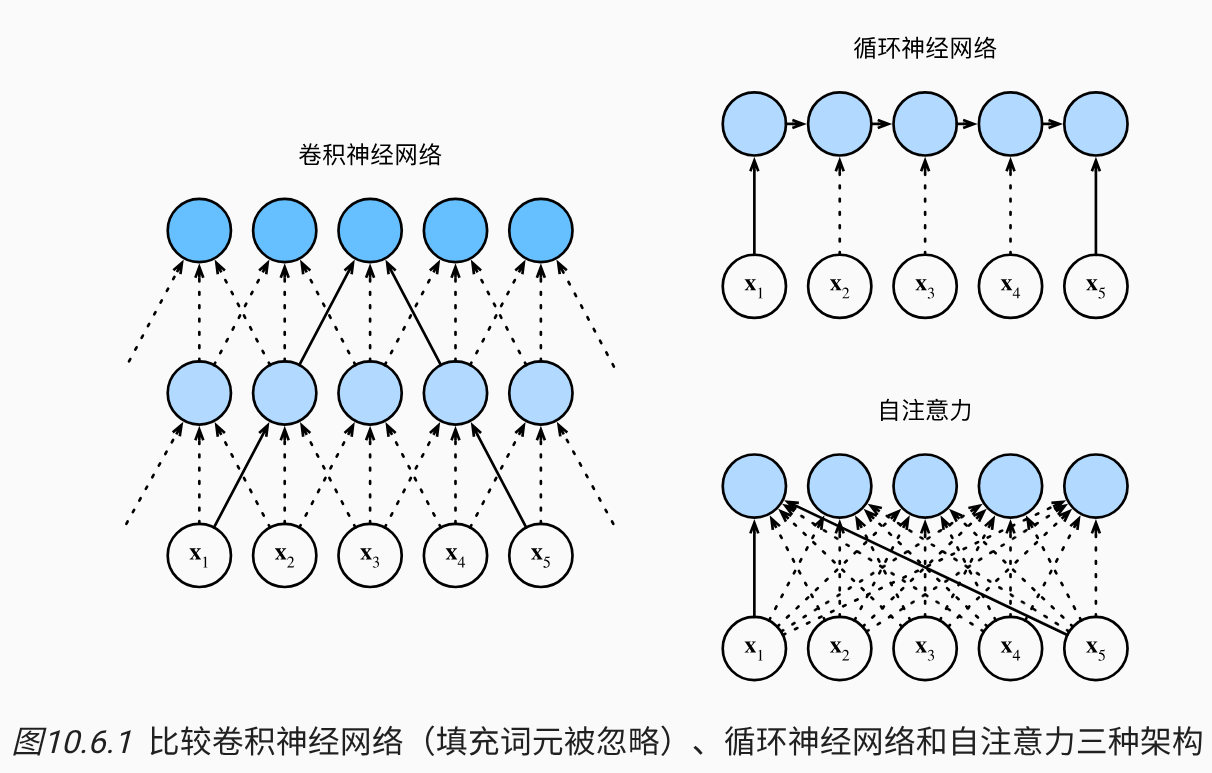
考虑一个卷积核大小为 $k$ 的卷积层, 在后面的章节将提供关于使用 `CNN` 处理序列的更多详细信息, 目前考虑, 序列长度为 $n$, 输入和输出的通道数都为 $d$(此时卷积核的大小为 `d*d*m*n`), 所以此时卷积层的计算复杂度为 $O(knd^2)$, 同时有与卷积神经网络是分层的, 所以总共存在 $O(1)$ 个顺序操作, 最大路径长度为 $O(\frac {n}{k})$ (通俗理解为, `CNN`相当于只考虑周围一部分数据的影响, 其实有一点类似于注意力机制, 但是只考虑周围的影响)

对于循环神经网络, 存在 $d \times d$权重矩阵以及 $d$ 维隐状态的乘法计算复杂度 $O(d^2)$, 有与序列长度为 $n$, 因此循环神经网络层的计算复杂度为 $O(nd^2)$, 并且 $O(n)$ 个顺序操作无法并行化, 最大路径长度为 $O(n)$

在自注意力中, 查询、键和值都是 $n \times d$矩阵, 考虑缩放点积注意力, 其中 $n \times d$ 矩阵乘以 $d \times n$ 矩阵, 以及输出的矩阵乘法, 所以自注意力计算复杂度为 $O(n^2d)$, 同时每一个词元都可以通过自注意力直接连接到其他任何词元, 所以总共有 $O(1)$ 个顺序操作可以并行计算, 最大路径长度为 $O(1)$

`CNN`和自注意力都具有并行计算的优势, 而且自注意力长度最短, 但是计算复杂度很大

## 位置编码
处理词元序列的时候, `RNN` 是逐个重复处理词元, 而自注意力则因为并行计算而放弃了顺序操作, 为了使用序列的顺序信息, 通过在输入标识中添加位置编码来注入绝对或者相对的位置信息, 位置编码鄂可以通过学习得到或者直接固定得到, 接下来描述正弦函数和余弦函数的固定位置编码

假设输入可以表示为 $\mathbf{X} \in \mathbb{R}^{n \times d}$ 包含一个序列中$n$个词元的 $d$ 维嵌入表示, 位置编码使用相同形状的位置嵌入矩阵 $\mathbf{P} \in \mathbb{R}^{n \times d}$ 输出 $\mathbf{X + P}$,矩阵第$i$行、第$2j$列和$2j + 1$列上的元素为:
$$
\begin{split}
p_{i,2j} &= \sin\left( \frac{i}{10000^{2^{j/d}}} \right), \\
p_{i,2j+1} &= \cos\left( \frac{i}{10000^{2^{j/d}}} \right).
\end{split}
$$

In [6]:
#@save
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个位置编码矩阵
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1,1) / torch.pow(1000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X) # 前两个维度任意, 最后一个维度 0 开始, 2 为步长
        self.P[:, :, 1::2] = torch.cos(X)
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

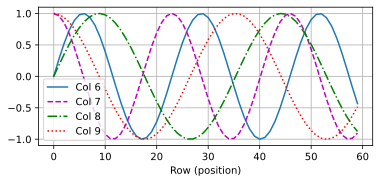

In [7]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

在位置嵌入矩阵 $\mathbf{P}$ 中, 行表示词元在序列中俄位置, 列表示位置编码的不同维度, 从上面的例子可以看出, 位置嵌入矩阵第 $6, 7$ 类出现频率高于第 $8, 9$列(所以位置编码存在的意义是什么?)

### 绝对位置信息
例如打印出 $0, 1, \ldots, 7$ 的二进制表示形式, 每一个数字二进制中的比特位存在固定的位置关系

In [13]:
for i in range(8):
    print(f'{i}的二进制为: {i:03b}')

0的二进制为: 000
1的二进制为: 001
2的二进制为: 010
3的二进制为: 011
4的二进制为: 100
5的二进制为: 101
6的二进制为: 110
7的二进制为: 111


对于位置编码而言, 位置编码使用三角函数在编码维度上降低频率, 有与输出为浮点数, 所以此类连续表示比二进制更加节省空间

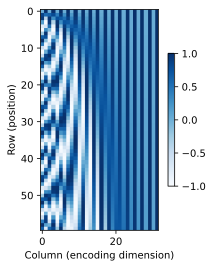

In [14]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

### 相对位置信息
处理捕获绝对位置信息之外, 上述的位置编码还允许模型学习得到输入序列中相对位置信息, 这是因为对于任何确定的位置偏移 $\delta$, 位置 $i+\delta$处的位置编码可以线性投影位置$i$处的位置编码来表示, 数学解释如下:

令 $\omega_j = \frac{1}{10000^{\frac{2j}{d}}}$, 对于任何确定的位置偏移, 任何一对 $(p_{i, 2j}, p_{i, 2j+1})$ 都可以线性投影到 $(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$:

$$
\begin{split}
&\begin{bmatrix} 
\cos(\delta\omega_j) & \sin(\delta\omega_j) \\ 
-\sin(\delta\omega_j) & \cos(\delta\omega_j) 
\end{bmatrix} 
\begin{bmatrix} 
p_{i,2j} \\ 
p_{i,2j+1} 
\end{bmatrix} \\
&= \begin{bmatrix} 
\cos(\delta\omega_j)\sin(i\omega_j) + \sin(\delta\omega_j)\cos(i\omega_j) \\ 
-\sin(\delta\omega_j)\sin(i\omega_j) + \cos(\delta\omega_j)\cos(i\omega_j) 
\end{bmatrix} \\
&= \begin{bmatrix} 
\sin\left((i + \delta)\omega_j\right) \\ 
\cos\left((i + \delta)\omega_j\right) 
\end{bmatrix} \\
&= \begin{bmatrix} 
p_{i+\delta,2j} \\ 
p_{i+\delta,2j+1} 
\end{bmatrix},
\end{split}
$$

## 思考
**Q1: 自注意力机制总结一下?**
注意自注意力机制类似于`CNN, RNN`, 可以看成是一个单一一层的网络, 利用一个输入序列, 经过网络得到一个等长的输出序列 ; 具体的实现方法就是 `K, V` 都使用输入序列来表, 查询使用对应的值来表示
**Q2: 位置编码有什么作用?**
如果没有位置编码, 在自注意力机制中, 我们可以发现, 对于输出位置, 每一个位置的计算方法都是类似的, 也就是词元的顺序此时无法区分, 位置编码的作用其实就是对于在经过自注意力机制变换之后的序列位置信息的一个明确, 也就是弥补模型对于序列顺序不敏感的缺陷(弥补自注意力实现过程中的位置信息丢失)